In [1]:
import os, sys
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm
from collections import defaultdict
import random
from rasterio import Affine, features
from shapely.geometry import shape
from shapely.ops import cascaded_union
from math import floor, ceil
from scipy.signal import fftconvolve


In [41]:
HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/pipeline_utility/src')
sys.path.append(PATH)
from lib.FileLocationManager import DATA_PATH

color_radius = 3
animals = ['MD585', 'MD589','MD594']
ATLAS = 'atlasV8'
structure = 'SC'
section = 200
shapes = []
for animal in animals:
    CSVPATH = os.path.join(DATA_PATH, 'atlas_data', ATLAS, animal)
    jsonpath = os.path.join(CSVPATH,  'aligned_structure_sections.json')
    with open(jsonpath) as f:
        aligned_dict = json.load(f)
    onestructure = aligned_dict[structure]
    start = int(min(onestructure.keys())) + 10
    points = onestructure[str(mins)]
    print(animal, len(points), start)
    shapes.append({'type': 'Polygon', 'coordinates': [points]})
    #arr = np.array(np.round(points)).astype(np.int32)

MD585 81 146
MD589 107 138
MD594 90 147


In [9]:
def gaussian_blur(in_array, gt, size):
    """Gaussian blur, returns tuple `(ar, gt2)` that have been expanded by `size`"""
    # expand in_array to fit edge of kernel; constant value is zero
    padded_array = np.pad(in_array, size, 'constant')
    # build kernel
    x, y = np.mgrid[-size:size + 1, -size:size + 1]
    g = np.exp(-(x**2 / float(size) + y**2 / float(size)))
    g = (g / g.sum()).astype(in_array.dtype)
    # do the Gaussian blur
    ar = fftconvolve(padded_array, g, mode='full')
    # convolved increased size of array ('full' option); update geotransform
    gt2 = Affine(
        gt.a, gt.b, gt.xoff - (2 * size * gt.a),
        gt.d, gt.e, gt.yoff - (2 * size * gt.e))
    return ar, gt2

In [36]:
max_shape = cascaded_union([shape(s) for s in shapes])
minx, miny, maxx, maxy = max_shape.bounds
print(minx,miny,maxx,maxy, len(shapes))

678.2327721684927 229.5178829550087 814.8770307877251 378.70710318016756 3


In [37]:
dx = dy = 1.0  # grid resolution; this can be adjusted
lenx = dx * (ceil(maxx / dx) - floor(minx / dx))
leny = dy * (ceil(maxy / dy) - floor(miny / dy))
assert lenx % dx == 0.0
assert leny % dy == 0.0
nx = int(lenx / dx)
ny = int(leny / dy)
gt = Affine(
    dx, 0.0, dx * floor(minx / dx),
    0.0, -dy, dy * ceil(maxy / dy))

pa = np.zeros((ny, nx), 'd')
for s in shapes:
    r = features.rasterize([s], (ny, nx), transform=gt)
    pa[r > 0] += 1
pa /= len(shapes)  # normalise values
print(type(pa), pa.dtype, pa.shape)
spa, sgt = gaussian_blur(pa, gt, 100)
print(type(spa), spa.dtype, spa.shape, type(sgt))

thresh = 0.5  # median
pm = np.zeros(spa.shape, 'B')
pm[spa > thresh] = 1
print('pm', type(pm), pm.dtype, pm.shape)

<class 'numpy.ndarray'> float64 (150, 137)
<class 'numpy.ndarray'> float64 (550, 537) <class 'affine.Affine'>
pm <class 'numpy.ndarray'> uint8 (550, 537)


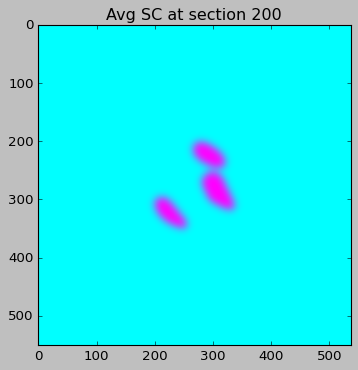

In [40]:
plt.style.use('classic')
plt.rcParams["figure.figsize"] = (8,5)
plt.title(f'Avg {structure} at section {section}')
plt.imshow(spa, cmap="cool")
plt.show()